In [1]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
datasetdir = '/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/images_scaled'
os.chdir(datasetdir)

In [4]:
# Load file locations
df_info = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'images.txt')

#Load class information
df_classes = pd.read_excel('/content/drive/MyDrive/MMAI 894 - DEEP LEARNING/TEAM PROJECT/dataset_information.xlsx', sheet_name = 'classes.txt')

In [5]:
#Split the class and image name
df_image = df_info.join(df_info['image_location'].str.split('/',expand=True).rename(columns={0:'class_id',1:'image_name'})) 

In [6]:
#Convert the string column to INT to chop leading zeroes
df_image['class_id'] = df_image['class_id'].astype(int)

In [7]:
#Join the information and class dataframe 
df_bird = pd.merge(df_image, df_classes, left_on='class_id', right_on='child_class_id', how='left').drop('child_class_id', axis=1)

In [8]:
#Find the count of bird class in case only specific classes need to be to the model
DF_classcounts = df_bird.groupby(['class_id'])['class_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 

In [9]:
DF_classcounts['count'].values

array([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117,
       117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
       116, 116, 116, 116, 115, 115, 115, 115, 114, 114, 114, 114, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112,
       111, 111, 111, 111, 111, 111, 111, 110, 110, 110, 110, 110, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 108, 10

## **Target Variables here: all classes with (Number of images) >= 60. Total 453 classes with 43955 images.**

In [10]:
#Selected only specific labels
target_class = DF_classcounts[(DF_classcounts['count']>=60) & (DF_classcounts['count']<=120)]['class_id'].values

df_bird['FILTERED_LABEL'] = (df_bird.class_id.isin(target_class)).astype('int')

In [11]:
DF_classcounts[(DF_classcounts['count']>=60) & (DF_classcounts['count']<=120)]['count'].sum()

43955

In [12]:
len(target_class)

453

In [13]:
df_target =  df_bird[df_bird['FILTERED_LABEL']==1]

In [14]:
len(df_target)

43955

In [15]:
# Move 'class_id' and 'image_location' into string type features 
df_target['class_id'] = df_target['class_id'].astype(str)
df_target['image_location'] = df_target['image_location'].astype(str)

In [16]:
datasetdir = '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled'
os.chdir(datasetdir)

**Split the data into train set 60%, validation set 15% and a test set 25%.**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_target['image_location'], df_target['class_id'], test_size=0.25, random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/5, train_size=4/5, random_state=44)

print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))
print("Number of posters for training: ", len(X_test))

Number of posters for training:  26372
Number of posters for validation:  6594
Number of posters for training:  10989


In [18]:
len(X_train) + len(X_val) + len(X_test)

43955

In [19]:
len(X_train)/len(df_target)

0.5999772494596747

In [20]:
len(X_val)/len(df_target)

0.150017062905244

In [21]:
len(X_test)/len(df_target)

0.25000568763508135

In [22]:
X_train = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_val = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_val]
#X_test = [os.path.join('/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/', str(f)) for f in X_train]
X_train[:5]

['/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0831/c387c0d6fa14497aaaf1ff3443154e5a.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0613/5e26b456cdda49c1ba8d70069008d833.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0767/931ee5a595d9438fbd8571024045713e.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0914/5ec283f8edeb4abb89307c45dda2ac41.jpg',
 '/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0395/bcb091b457b944a193a5f5d5c2201c35.jpg']

In [23]:
X_train[1]

'/content/drive/.shortcut-targets-by-id/17pVG9Sy8XzdWBm7-KrdDnpAmGyZRy0Vc/images_scaled/0613/5e26b456cdda49c1ba8d70069008d833.jpg'

**For simplicity, let's encode our target labels into one-hot encoded labels using preprocessing.LabelBinarizer().**

In [23]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
lb.fit(y_val)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [24]:
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)
y_test_bin = lb.transform(y_test)

**Model Inception ResNet V2 preferes images with shape of (299, 299, 3).**

In [25]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
N_CLASSES = len(lb.classes_)

**Create a function that normalize and resize images inputs to the fixed shape required by the model.**

In [26]:
def parse_img_label(filename, label):
    
    
    # Read an image from a file
    image_string = tf.io.read_file(filename)

    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)

    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])

    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    
    return image_normalized, label

In [27]:
BATCH_SIZE = 512 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 512 # Shuffle the training data by a chunck of 512 observations

In [28]:
def gen_dataset(filenames, labels, is_training=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_img_label, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [29]:
train_ds = gen_dataset(X_train, y_train_bin)
val_ds = gen_dataset(X_val, y_val_bin)
test_ds = gen_dataset(X_test, y_test_bin)

In [31]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (512, 224, 224, 3)
Shape of labels array: (512, 453)


In [30]:
def macro_f1(y, y_hat, thresh=0.5): 
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

# **ResNet_v2_152**

In [31]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, trainable=False,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [34]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              58331648  
_________________________________________________________________
output (Dense)               (None, 453)               928197    
Total params: 59,259,845
Trainable params: 928,197
Non-trainable params: 58,331,648
_________________________________________________________________


In [35]:
batch_size = 256
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])   # Default is k = 5
    
history = model.fit(train_ds, epochs=40,batch_size = batch_size, validation_data = val_ds,
                             validation_batch_size = batch_size)


Epoch 1/40
52/52 [==============================] - 2610s 51s/step - loss: 0.2332 - macro_f1: 0.0000e+00 - accuracy: 0.0023 - top_k_categorical_accuracy: 0.0111 - val_loss: 0.0204 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0029 - val_top_k_categorical_accuracy: 0.0130
Epoch 2/40
52/52 [==============================] - 104s 2s/step - loss: 0.0196 - macro_f1: 0.0000e+00 - accuracy: 0.0041 - top_k_categorical_accuracy: 0.0194 - val_loss: 0.0191 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0120 - val_top_k_categorical_accuracy: 0.0420
Epoch 3/40
52/52 [==============================] - 104s 2s/step - loss: 0.0184 - macro_f1: 0.0000e+00 - accuracy: 0.0218 - top_k_categorical_accuracy: 0.0635 - val_loss: 0.0180 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0435 - val_top_k_categorical_accuracy: 0.1031
Epoch 4/40
52/52 [==============================] - 104s 2s/step - loss: 0.0172 - macro_f1: 1.5087e-04 - accuracy: 0.0586 - top_k_categorical_accuracy: 0.1420 - val_loss: 0.0170 - val_macro_f

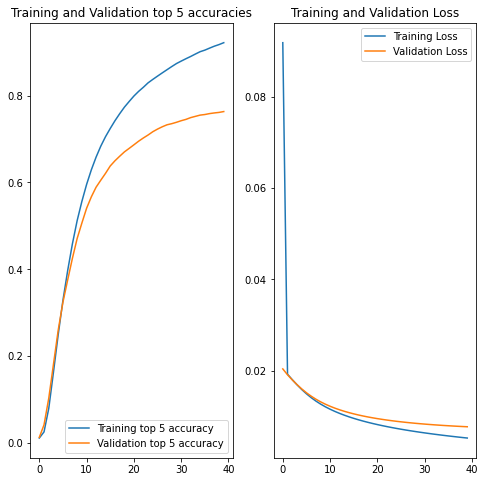

In [36]:
top5_acc = history.history['top_k_categorical_accuracy']
val_top5_acc = history.history['val_top_k_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, top5_acc, label='Training top 5 accuracy')
plt.plot(epochs_range, val_top5_acc, label='Validation top 5 accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation top 5 accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

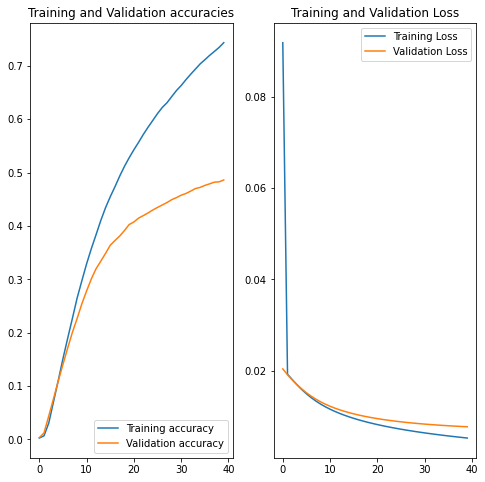

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

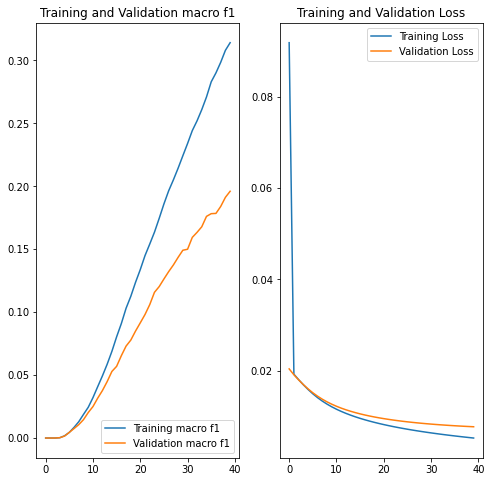

In [38]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Result = model.evaluate(test_ds)

 7/22 [========>.....................] - ETA: 10:14 - loss: 0.0076 - macro_f1: 0.1852 - accuracy: 0.4975 - top_k_categorical_accuracy: 0.7732

In [32]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(2048, activation='relu', name='hidden_layer1'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu', name='hidden_layer2'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu', name='hidden_layer3'),
    layers.Dropout(0.2),
    layers.Dense(N_CLASSES, activation='softmax', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              58331648  
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [33]:
batch_size = 256
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1, 'accuracy', tf.keras.metrics.TopKCategoricalAccuracy()])   # Default is k = 5
    
history = model.fit(train_ds, epochs=40,batch_size = batch_size, validation_data = val_ds,
                             validation_batch_size = batch_size)

Epoch 1/40
52/52 [==============================] - 1840s 35s/step - loss: 0.1955 - macro_f1: 1.5285e-04 - accuracy: 0.0022 - top_k_categorical_accuracy: 0.0112 - val_loss: 0.0168 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0070 - val_top_k_categorical_accuracy: 0.0256
Epoch 2/40
52/52 [==============================] - 104s 2s/step - loss: 0.0185 - macro_f1: 0.0000e+00 - accuracy: 0.0030 - top_k_categorical_accuracy: 0.0132 - val_loss: 0.0158 - val_macro_f1: 0.0000e+00 - val_accuracy: 0.0358 - val_top_k_categorical_accuracy: 0.0980
Epoch 3/40
52/52 [==============================] - 104s 2s/step - loss: 0.0170 - macro_f1: 2.3033e-05 - accuracy: 0.0070 - top_k_categorical_accuracy: 0.0295 - val_loss: 0.0146 - val_macro_f1: 2.8301e-04 - val_accuracy: 0.0725 - val_top_k_categorical_accuracy: 0.1912
Epoch 4/40
52/52 [==============================] - 104s 2s/step - loss: 0.0154 - macro_f1: 8.0719e-04 - accuracy: 0.0306 - top_k_categorical_accuracy: 0.0964 - val_loss: 0.0127 - val_macro_f

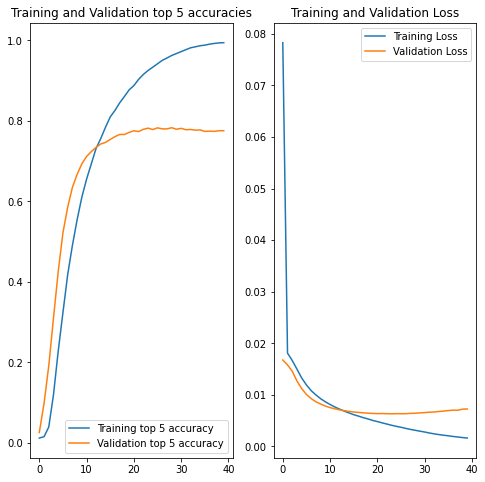

In [34]:
top5_acc = history.history['top_k_categorical_accuracy']
val_top5_acc = history.history['val_top_k_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, top5_acc, label='Training top 5 accuracy')
plt.plot(epochs_range, val_top5_acc, label='Validation top 5 accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation top 5 accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

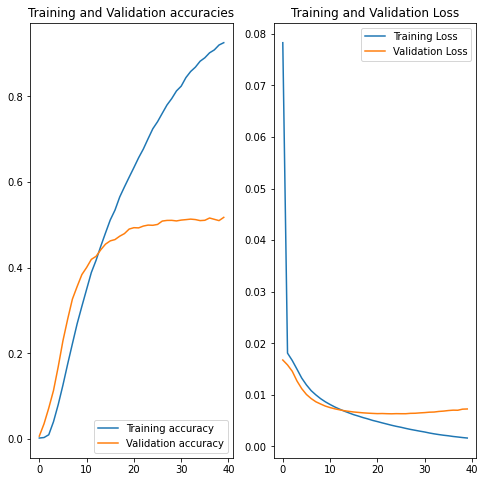

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracies')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

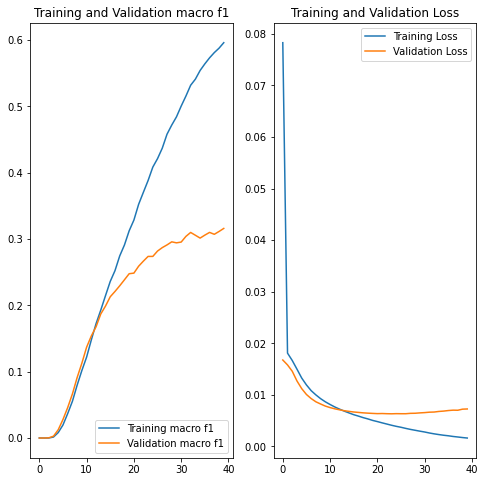

In [36]:
mf1 = history.history['macro_f1']
val_mf1 = history.history['val_macro_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mf1, label='Training macro f1')
plt.plot(epochs_range, val_mf1, label='Validation macro f1')
plt.legend(loc='lower right')
plt.title('Training and Validation macro f1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Result = model.evaluate(test_ds)

 8/22 [=========>....................] - ETA: 5:42 - loss: 0.0071 - macro_f1: 0.3175 - accuracy: 0.5247 - top_k_categorical_accuracy: 0.7883